# Displaced ID efficiency studies with TnP on analytix spark cluster and parquet files

This notebook describes several studies involving the new Displaced ID to be supported by the Muon POG. 
It also serves (hopefully) as a useful example of the kinds of things that can be done with the new TnP framework based on spark.
The notebook version allows one to run several exploratory analyses, with quick iterating and prototyping.
For the ultimate efficiencies and scale factors, it's recommended to run the script version instead, described on the main repo README page.
The script computes efficiencies and scale factors for all defined IDs at once and uses the fitter for it. Here we just use cut-and-count.

## Check spark

First of all make sure spark object is created.

In [2]:
spark

## Load system modules

In [3]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt

if 'notebooks' in os.getcwd():
    os.chdir('..')

In [4]:
# For playing a beep at the end of very long computations
from IPython.display import Audio
sound_file = 'http://www.soundjay.com/button/beep-07.wav'
# Paste the following code at the bottom of a long-running cell:
# Audio(sound_file, autoplay=True)

## Load package modules

Including the config to be used throughout the notebook.

In [5]:
from flattener import *
from registry import registry
from config import Configuration
my_config = Configuration('configs/displacedID_Z.json')
# my_config = Configuration('configs/displacedID_Z_truth.json')
# my_config = Configuration('configs/displacedID_JPsi.json')

## Recreate the dataframe

Let's recreate the dataframe and use it interactively to plot efficiencies.

In [6]:
def get_df(resonance,era,subEra,config=my_config):

    useParquet = True
    
    if useParquet:
        fnames = list(registry.parquet(
            particle, probe, resonance, era, subEra))
        print(fnames)
    else:
        fnames = registry.root(particle, probe, resonance, era, subEra)
        fnames = ['root://eoscms.cern.ch/'+f for f in fnames]

    doGen = subEra in ['DY_madgraph', 'JPsi_pythia8']

    # default numerator/denominator defintions
    definitions = config.definitions()

    # for when we use root files instead of parquet
    #treename = 'tpTree/fitter_tree'
    treename = 'muon/Events'
    
    # get the dataframe
    if useParquet:
        print('Loading parquet files:', fnames)
        if isinstance(fnames, list):
            baseDF = spark.read.parquet(*fnames)
        else:
            baseDF = spark.read.parquet(fnames)
    else:
        treename = registry.treename(particle, probe, resonance, era, subEra)
        baseDF = spark.read.format("root")\
                      .option('tree', treename)\
                      .load(fnames)
        
    defDF = baseDF
    for d in definitions:
        defDF = defDF.withColumn(d, F.expr(definitions[d]))

    # select tags
    tagsDF = defDF.filter(config.selection())        
        
    # build the weights (pileup for MC)
    weightedDF = get_weighted_dataframe(tagsDF, doGen, resonance, era, subEra)
    
    # create the binning structure
    fitVariable = config.fitVariable()
    binningSet = set([fitVariable])
    if doGen:
        fitVariableGen = config.fitVariableGen()
        binningSet = binningSet.union(set([fitVariableGen]))
    binVariables = config.binVariables()
    for bvs in binVariables:
        binningSet = binningSet.union(set(bvs))

    binning = config.binning()
    variables = config.variables()
    binnedDF = weightedDF
    for bName in binningSet:
        binnedDF = get_binned_dataframe(
            binnedDF, bName+"Bin",
            variables[bName]['variable'],
            binning[bName])

    return binnedDF

In [9]:
particle = 'muon'
probe = 'dSAMuons'
resonance = 'Z'
# resonance = 'JPsi'

era = 'Run2016'
subEras = ['Run2016B', 'DY_madgraph']
data_subera = subEras[0] # or None if only MC
# subEras = ['Run2018A', 'JPsi_pythia8'] # For J/psi

dfs = {subEra: get_df(resonance,era,subEra) for subEra in subEras}
# Create derived sets from original df
dfs_pt20 = {subEra: dfs[subEra].filter('probe_dsa_pt>20') for subEra in subEras} # for use with no pT binned plots
dfs_dsa = {subera: dfs[subera].filter('probe_isdSA==1') for subera in subEras}
dfs_gen = {subera: dfs_dsa[subera].filter('tag_isMatchedGen==1 and probe_isMatchedGen==1') for subera in subEras}

['/user/asterenb/parquet/muon/Z/Run2016/Run2016B/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2016/Run2016B/tnp.parquet']
['/user/asterenb/parquet/muon/Z/Run2016/DY_madgraph/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2016/DY_madgraph/tnp.parquet']


## Plot quantities

Example plotting several relevant distributions. Some of these quantities were defined in 'definitions' section of config file (e.g. 'displacedID_Z.json'), while others were already available as branches in the ntuple.

In [7]:
def plot(dfs, plotVar, edges, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    # data = None
    # if 'Run2018A' in dfs.keys():
    #    data = 'Run2018A'

    def reduce_df(df):
        df = get_binned_dataframe(df, 'tmpBin', plotVar, edges)
        df = df.groupBy('tmpBin').agg({'weight': 'sum', 'weight2': 'sum'})
        df = df.withColumnRenamed('sum(weight)','sumw')
        df = df.withColumnRenamed('sum(weight2)','sumw2')
        df = df.toPandas().set_index('tmpBin').sort_index()
        return df
    
    if data_subera is not None:
        df = reduce_df(dfs[data_subera])
    if sim is not None:
        df_mc = reduce_df(dfs[sim])
    
    bx = edges
    if data is not None:
        y = pd.Series(np.zeros(len(edges)+1))
        yerr = pd.Series(np.zeros(len(edges)+1))
    if sim is not None:
        y_mc = pd.Series(np.zeros(len(edges)+1))
        yerr_mc = pd.Series(np.zeros(len(edges)+1))
    
    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if data is not None:
        y[df.index] = df['sumw']
        integral = sum(y)
        y = y/integral
        y = y[1:len(bx)]
        yerr[df.index] = np.sqrt(df['sumw2']) 
        yerr = yerr / integral
        yerr = yerr[1:len(bx)]
    
    if sim is not None:
        y_mc[df_mc.index] = df_mc['sumw']
        integral_mc = sum(y_mc)
        y_mc = y_mc / integral_mc
        y_mc = y_mc[1:len(bx)]
        yerr_mc[df_mc.index] = np.sqrt(df_mc['sumw2']) 
        yerr_mc = yerr_mc / integral_mc
        yerr_mc = yerr_mc[1:len(bx)]
    
    if data is not None:
        plt.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
        # plt.yscale('log')
    if sim is not None:
        plt.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        
    leg = []
    leg += ['Data'] if data is not None else ''
    leg += ['Simulation'] if sim is not None else ''
    plt.legend(leg,frameon=False)
        
    plt.ylabel('Unit normalized')
    plt.xlabel(xlabel)
    if additional_text: 
        plt.text(bx[0],0.95*max([max(y),max(y_mc if sim is not None else 0.0)]), additional_text)
    plt.show()

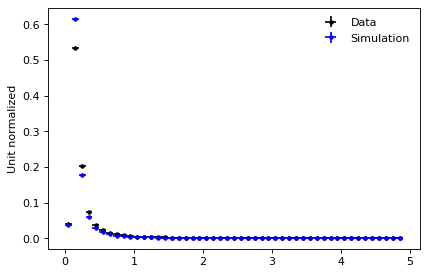

In [10]:
plot(dfs_dsa, 'probe_dsa_pterr', np.array(np.arange(0,5,.1)))

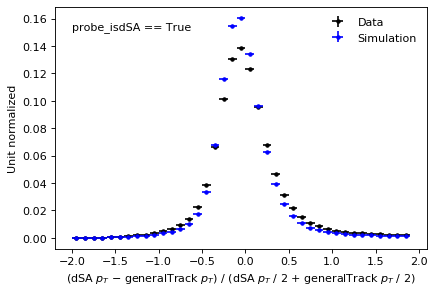

In [12]:
plot(dfs_dsa, 'diff_dsa_trk_pt', np.array(np.arange(-2, 2, 0.1)), 
     xlabel='(dSA $p_{T}$ $-$ generalTrack $p_{T}$) / (dSA $p_{T}$ / 2 $+$ generalTrack $p_{T}$ / 2)', 
     additional_text='probe_isdSA == True', high_quality=False)

plot(dfs_dsa, 'diff_dsa_trk_eta', np.array(np.arange(-0.05, 0.055, 0.0025)), 
     xlabel='(dSA $\eta$ $-$ generalTrack $\eta$) / (dSA $\eta$ / 2 $+$ generalTrack $\eta$ / 2)',
     additional_text='probe_isdSA == True', high_quality=False)

plot(dfs_dsa, 'diff_dsa_trk_phi', np.array(np.arange(-0.1, 0.11, 0.005)), 
     xlabel='(dSA $\phi$ $-$ generalTrack $\phi$) / (dSA $\phi$ / 2 $+$ generalTrack $\phi$ / 2)', 
     additional_text='probe_isdSA == True', high_quality=False)

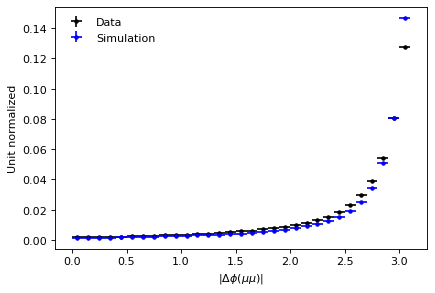

In [15]:
plot(dfs_dsa, 'pair_reduced_dphi', np.array(np.arange(0, 3.2, .1)), 
     xlabel=r'$|\Delta\phi(\mu\mu)|$', high_quality=False)

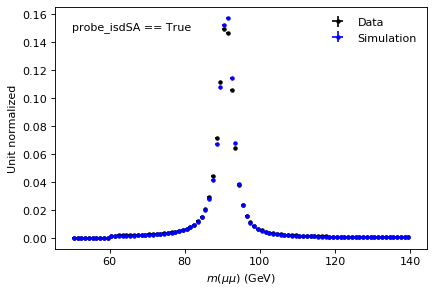

In [16]:
# plot(dfs_pt20, 'pair_mass', np.array(range(40,161,1)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text=r'$p_{T} > 20$ (GeV)')
# plot(dfs_dsa, 'pair_mass', np.array(np.arange(2.8,3.4,0.01)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text='probe_isdSA == True', high_quality=True)
plot(dfs_dsa, 'pair_mass', np.array(np.arange(50,141,1)), xlabel=r'$m(\mu\mu)$ (GeV)', 
     additional_text='probe_isdSA == True', high_quality=False)
# plot(dfs, 'pair_mass', np.array(range(1,10,1)), xlabel=r'$m(\mu\mu)$ (GeV)', additional_text=r'$p_{T} > 20$ (GeV)')

## Single ID efficiency

Grab the efficiency of the `DisplacedID` with `dSAMuons` as a denominator.
This will be a cut-and-count efficiency. Both num and denom are defined in the config file.

In [8]:
def get_params(df,num,den,binVars,cutAndCount=True):

    reducedDF = df.filter(df[den]==True)

    reducedDF = reducedDF.withColumn('den',F.lit(den))
    reducedDF = reducedDF.withColumn('num',F.lit(num))
    reducedDF = reducedDF.withColumnRenamed(num,'pass')

    reducedDF = reducedDF.groupBy('pass','num','den',*[b+'Bin' for b in list(binVars)+['mass']]).agg({'weight': 'sum', 'weight2': 'sum'})
    reducedDF = reducedDF.withColumnRenamed('sum(weight)','sumw')
    reducedDF = reducedDF.withColumnRenamed('sum(weight2)','sumw2')

    # for wrapping a fit
    #fit_wrapper = FitWrapper(crystalball_exponential)
    #fit_udf = fit_wrapper()
    #fitparams = summedDF.groupby(['pass','num','den','absetaBin','ptBin']).apply(fit_udf)
    #realized = fitparams.toPandas()

    if cutAndCount:
        # for simple cut and count
        narrowWindow = reducedDF #.filter('massBin >= 31 and massBin <= 41')
        countsDF = narrowWindow.groupby(['pass','num','den']+[b+'Bin' for b in list(binVars)]).agg({'sumw': 'sum', 'sumw2': 'sum'})
        countsDF = countsDF.withColumnRenamed('sum(sumw)','sumw')
        countsDF = countsDF.withColumnRenamed('sum(sumw2)','sumw2')
        realized = countsDF.toPandas()
    else:
        realized = reducedDF.toPandas()

    return realized

In [12]:
# num, den = 'TightID', 'TrackerMuons'
num, den = 'DisplacedID', 'dSAMuons'
realized_abseta_pt = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

The returned dataframe has keys for the numerator, denominator, pass/fail, and the binning structure chosen (bin indices are just numbers, they don't correspond to any physical units).

Now, let's plot these efficiencies. Four plots are shown for the four `abseta` bins in the 2D binning structure we chose.

In [9]:
def get_eff(df,binVars):
    '''return a df with keys eff, eff_err, num, den, ... '''
    df_num = df[df['pass']==True].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_den = df[df['pass']==False].set_index(['num','den']+[b+'Bin' for b in binVars]).sort_index()
    df_num['eff'] = df_num['sumw'] / (df_den['sumw'] + df_num['sumw'])
    # TODO binomial with w!=1
    p = df_num['sumw']
    f = df_den['sumw']
    N = p+f
    df_num['eff_err'] = 1/N * np.sqrt(p*(1-p/N))
    return df_num[['eff','eff_err']]


def plot_eff(dfs, num, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = my_config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = data_subera if data_subera in dfs.keys() else None
    
    # df = dfs['Run2017C']
    if data is not None:
        df = dfs[data]
    if sim is not None:
        df_mc = dfs[sim]

    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if data is not None:
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
    if sim is not None:
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
    
    if sim is not None and data is not None:
        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
    else:
        fig, ax0 = plt.subplots(1)
        
    if data is not None:
        ax0.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        
    leg = []
    leg += ['Data'] if data is not None else ''
    leg += ['Simulation'] if sim is not None else ''
    ax0.legend(leg, frameon=False)
        
    ax0.set_ylabel('Efficiency')
    ax0.set_ylim(0.8,1.1)
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.9, f'{num} / {den}', transform=ax0.transAxes)
    ax0.text(0.05, 0.8, additional_text, transform=ax0.transAxes)
    # data lumi text
    lumi = registry.luminosity(particle, probe, resonance, era, data_subera)
    if data is not None:
        ax0.text(0.68, 1.02, rf'{data_subera}: {lumi} fb$^{{{-1}}}$', transform=ax0.transAxes)
    
    if sim is not None and data is not None:
        ratio = y/y_mc
        err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,yerr=err_ratio,fmt='.r')
        ax1.set_ylabel('Data/Simulation')
        ax1.set_ylim(0.8,1.05)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    ax0.label_outer()
    
    fig.show()

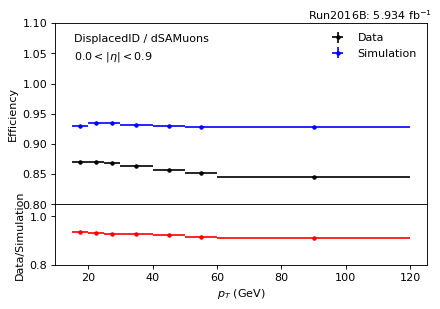

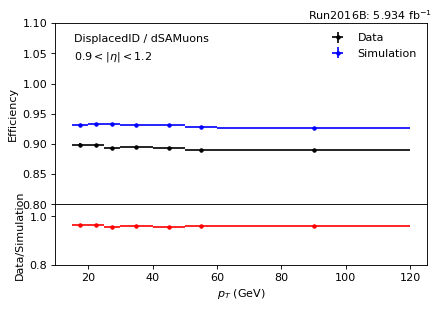

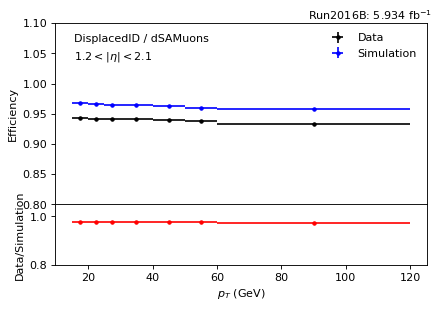

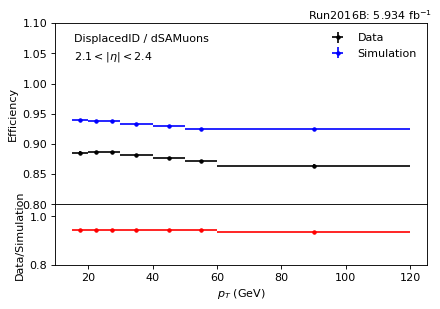

In [32]:
df_eff = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_eff(reduced_eff, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

You can see the raw efficiencies here.

In [25]:
df_eff['Run2018A']

eff   eff_err
num         den      absetaBin ptBin                    
DisplacedID dSAMuons 1.0       0.0    0.876179  0.008258
                               1.0    0.878511  0.003760
                               2.0    0.876881  0.002054
                               3.0    0.874191  0.001264
                               4.0    0.873458  0.000521
                               5.0    0.870040  0.000427
                               6.0    0.868256  0.000827
                               7.0    0.864669  0.001040
                               8.0    0.845622  0.003401
                     2.0       0.0    0.911940  0.010948
                               1.0    0.904762  0.006193
                               2.0    0.905644  0.003544
                               3.0    0.903177  0.002217
                               4.0    0.900934  0.000900
                               5.0    0.900518  0.000700
                               6.0    0.900178  0.001364
                               7.0    0.898671  0.001746
                               8.0    0.882533  0.005941
                     3.0       0.0    0.944583  0.005112
                               1.0    0.936691  0.003198
                               2.0    0.940932  0.001779
                               3.0    0.942270  0.001115
                               4.0    0.942036  0.000468
                               5.0    0.940465  0.000360
                               6.0    0.939413  0.000701
                               7.0    0.936214  0.000940
                               8.0    0.934307  0.003191
                     4.0       0.0    0.916201  0.011957
                               1.0    0.889682  0.007981
                               2.0    0.899550  0.004511
                               3.0    0.892385  0.003078
                               4.0    0.894168  0.001365
                               5.0    0.892885  0.001164
                               6.0    0.889782  0.002270
                               7.0    0.884562  0.003189
                               8.0    0.875969  0.012979
                     5.0       0.0    0.400000  0.109545
                               1.0    0.484375  0.062469
                               2.0    0.496894  0.039405
                               3.0    0.571906  0.028615
                               4.0    0.531436  0.012837
                               5.0    0.545817  0.011878
                               6.0    0.580087  0.022962
                               7.0    0.561086  0.033382
                               8.0    0.642857  0.128060

## N-1 efficiency studies

Here we define a slightly different set of functions from the ones above to specifically make N-1 plots (currently code is specialized to Z only).

In [10]:
def plot_nminus1_eff(dfs_sets, den, plotVar, plot_type='Data', xlabel='', additional_text='', high_quality=False):
    sample = 'Run2018A' if plot_type == 'Data' else 'DY_madgraph'
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        df = dfs_val[sample]
    
        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]

        ax0.errorbar(x,y,xerr=xerr,yerr=yerr, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Efficiency')
    ax0.set_xlabel(xlabel)
    top_lim = 1.20
    ax0.set_ylim(0.75, top_lim)
    ax0.text(bx[0], top_lim - 0.03, plot_type)
    ax0.text(bx[0], top_lim - 0.06,'Den: dSAMuons')
    ax0.text(bx[0], top_lim - 0.09, additional_text)
        
    fig.show()
    
def plot_nminus1_sf(dfs_sets, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        
        df = dfs_val['Run2018A']
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
        df_mc = dfs_val['DY_madgraph']
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
        
        ratio = y/y_mc
        err_ratio = ratio * ((yerr/y)**2 + (yerr_mc/y_mc)**2)**0.5
        
        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]

        ax0.errorbar(x,ratio,xerr=xerr,yerr=err_ratio, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Data/Simulation')
    ax0.set_xlabel(xlabel)
    top_lim = 1.1
    ax0.set_ylim(0.9, top_lim)
    ax0.text(bx[0], top_lim - 0.02,'Den: dSAMuons')
    ax0.text(bx[0], top_lim - 0.04, additional_text)
        
    fig.show()

Get the pass and fail histograms for each ID (defined in the config file).

In [62]:
subEras = ['Run2018A', 'DY_madgraph']

In [63]:
dfs_sets = {}

num, den = 'DisplacedID', 'dSAMuons'
dfs_sets[num] = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

num, den = 'DisplacedIDNoMuonHits', 'dSAMuons'
dfs_sets[num] = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

num, den = 'DisplacedIDNoMuonStations', 'dSAMuons'
dfs_sets[num] = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

num, den = 'DisplacedIDNoPtErr', 'dSAMuons'
dfs_sets[num] = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

num, den = 'DisplacedIDNoChi2', 'dSAMuons'
dfs_sets[num] = {subEra: get_params(dfs[subEra], num, den,('abseta','pt')) for subEra in subEras}

Plot all efficiencies overlaid with different styles to get around overlap. The line style choices are meant to be able to discern the different cuts when they are mostly overlapping. One can choose 'Data' or 'Simulation' to see the effect on each.

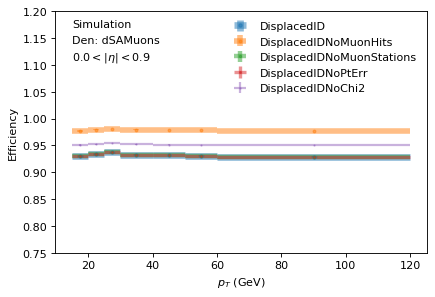

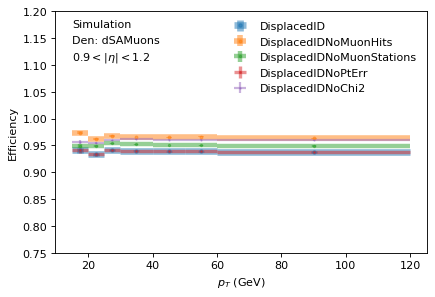

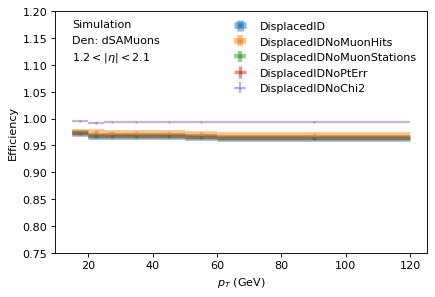

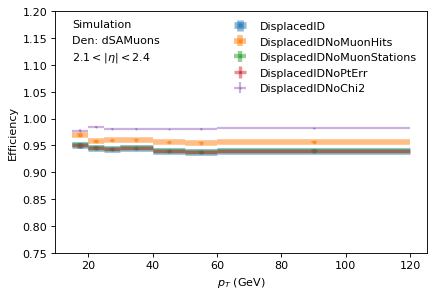

In [29]:
dfs_eff_sets = {}
for dfs_key, dfs_val in dfs_sets.items():
    dfs_eff_sets[dfs_key] = {subEra: get_eff(dfs_val[subEra], ('abseta','pt')) for subEra in subEras}
    
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    dfs_reduced_eff_sets = {}
    for dfs_eff_key, dfs_eff_val in dfs_eff_sets.items():
        dfs_reduced_eff_sets[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[dfs_eff_key,den,absetaBin,:]] for subEra in subEras}
        
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_nminus1_eff(dfs_reduced_eff_sets, den, 'pt', plot_type='Simulation', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text, high_quality=False)

We can also plot N-1 scale factors ('Data'/'Simulation').

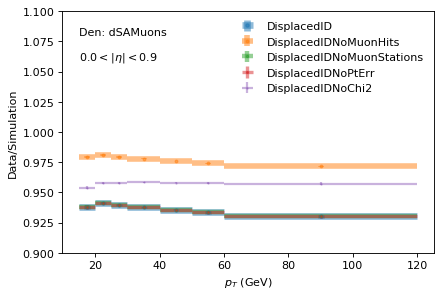

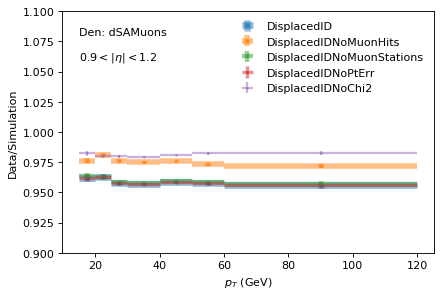

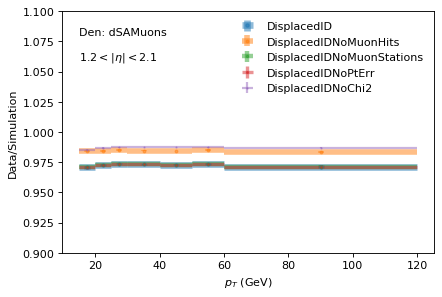

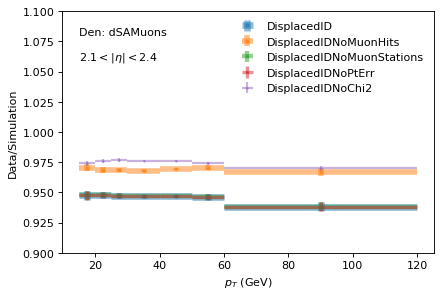

In [64]:
dfs_eff_sets = {}
for dfs_key, dfs_val in dfs_sets.items():
    dfs_eff_sets[dfs_key] = {subEra: get_eff(dfs_val[subEra], ('abseta','pt')) for subEra in subEras}
    
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    dfs_reduced_eff_sets = {}
    for dfs_eff_key, dfs_eff_val in dfs_eff_sets.items():
        dfs_reduced_eff_sets[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[dfs_eff_key,den,absetaBin,:]] for subEra in subEras}
        
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_nminus1_sf(dfs_reduced_eff_sets, den, 'pt', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text, high_quality=False)

Here it is clear the discrepancy between MC and data efficiencies is driven by the number of muon hits and the track chi2 (which may be correlated).

## dR match studies

In this section we look at different variations of dR matching between generalTracks and dSA tracks, and how the efficiency changes accordingly. The dR values tested are 0.1, 0.2, 0.3 and 0.4. Each value requires a re-run of the ntuplizer since the matching that selects the probes happens at the CMSSW analyzer level.

In [49]:
particle = 'muon'
probe = 'dSAMuons'
resonance = 'Z'
eras = ['Run2018_dR0p1', 'Run2018_dR0p2', 'Run2018_dR0p3', 'Run2018_dR0p4']
subEras = ['Run2018A', 'DY_madgraph']

dfs = {era: {subEra: get_df(resonance,era,subEra) for subEra in subEras} for era in eras}

['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p1/DY_madgraph_2018/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco/DY_madgraph_2018/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/Run2018A/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/Run2018A/tnp.parquet']
['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/DY_madgraph_2018/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/EOY_ReReco_dR0p3/DY_ma

Here we are testing the same DisplacedID for all dR matches.

In [50]:
dfs_params = {}

num, den = 'DisplacedID', 'dSAMuons'

dfs_params = {era: {subEra: get_params(dfs[era][subEra], num, den, ('abseta','pt')) for subEra in subEras} for era in eras}

We also define specific plot functions to handle the several dRs.

In [35]:
def plot_dR_eff(dfs_sets, den, plotVar, plot_type='Data', xlabel='', additional_text='', high_quality=False):
    sample = 'Run2018A' if plot_type == 'Data' else 'DY_madgraph'
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        df = dfs_val[sample]
    
        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]

        ax0.errorbar(x,y,xerr=xerr,yerr=yerr, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Efficiency')
    ax0.set_xlabel(xlabel)
    top_lim = 1.20
    ax0.set_ylim(0.75, top_lim)
    ax0.text(bx[0], top_lim - 0.03, plot_type)
    ax0.text(bx[0], top_lim - 0.06,'Den: dSAMuons')
    ax0.text(bx[0], top_lim - 0.09, additional_text)
        
    fig.show()
    
def plot_dR_sf(dfs_sets, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    
    bx = my_config.binning()[plotVar]

    fig, ax0 = plt.subplots(1) #, figsize=(8,6))
    
    lw = len(dfs_sets) + 1
    for dfs_key, dfs_val in dfs_sets.items():
        
        df = dfs_val['Run2018A']
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
        df_mc = dfs_val['DY_madgraph']
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
        
        ratio = y/y_mc
        err_ratio = ratio * ((yerr/y)**2 + (yerr_mc/y_mc)**2)**0.5
        
        x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
        xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]

        ax0.errorbar(x,ratio,xerr=xerr,yerr=err_ratio, fmt='.', alpha=0.5, markersize=lw, linewidth=lw, color=ax0._get_lines.get_next_color(), label=f'{dfs_key}')
        lw -= 1
        
    ax0.legend(frameon=False, loc='upper right')
        
    ax0.set_ylabel('Data/Simulation')
    ax0.set_xlabel(xlabel)
    top_lim = 1.1
    ax0.set_ylim(0.9, top_lim)
    ax0.text(bx[0], top_lim - 0.02,'Den: dSAMuons')
    ax0.text(bx[0], top_lim - 0.04, additional_text)
        
    fig.show()

Plot the efficiencies measured for the different dR matches. One can choose 'Data' or 'Simulation' to compare.

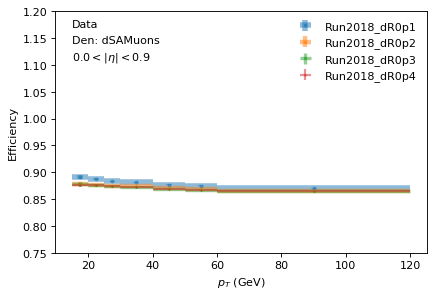

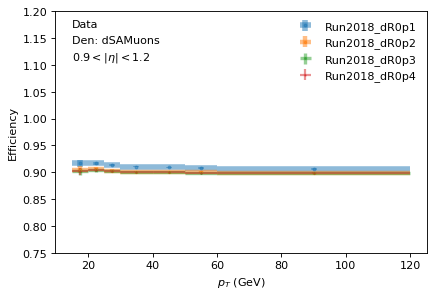

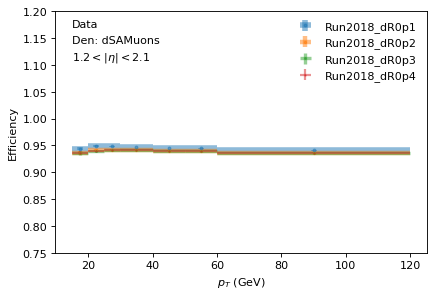

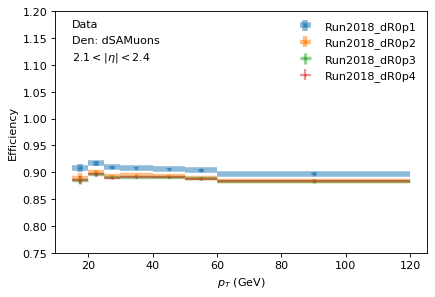

In [51]:
dfs_effs = {}
for dfs_key, dfs_val in dfs_params.items():
    dfs_effs[dfs_key] = {subEra: get_eff(dfs_val[subEra], ('abseta','pt')) for subEra in subEras}
    
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    dfs_reduced_effs = {}
    for dfs_eff_key, dfs_eff_val in dfs_effs.items():
        dfs_reduced_effs[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
        
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_dR_eff(dfs_reduced_effs, den, 'pt', plot_type='Data', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text, high_quality=False)

We can also plot the scale factor (Data/Simulation) for the different dR matches.

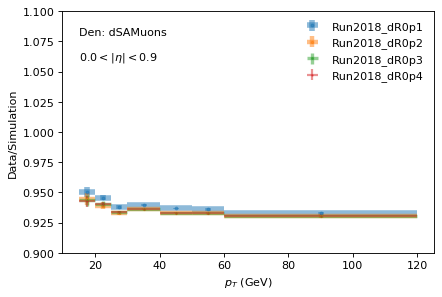

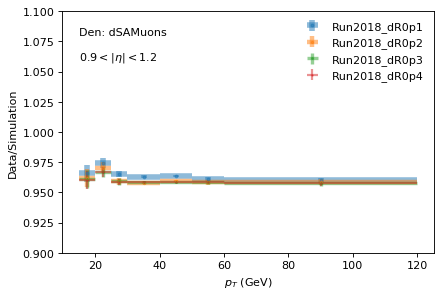

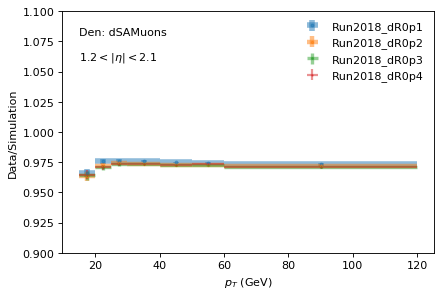

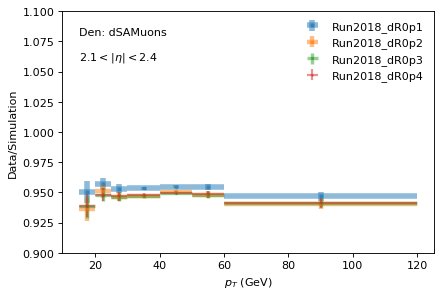

In [52]:
dfs_effs = {}
for dfs_key, dfs_val in dfs_params.items():
    dfs_effs[dfs_key] = {subEra: get_eff(dfs_val[subEra], ('abseta','pt')) for subEra in subEras}
    
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    dfs_reduced_effs = {}
    for dfs_eff_key, dfs_eff_val in dfs_effs.items():
        dfs_reduced_effs[dfs_eff_key] = {subEra: dfs_eff_val[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras}
        
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_dR_sf(dfs_reduced_effs, den, 'pt', xlabel=r'$p_{T}$ (GeV)', additional_text=additional_text, high_quality=False)

Notably, the efficiency does not vary much as a function of dR matching for the ID measurement. This means pileup is likely not a significant issued in our selection for the ID case. There is more variation in the dSA reconstruction efficiency (see 'dSA_reco_studies.ipnyb').

## Plotting Z and J/Psi together

Here we study the Displaced ID efficiency for both Z and J/Psi together in the same plot. The motivation is to ensure that the efficiencies are the same at the intermediate pT boundary regardless of physical system used to measure them.

Load both configs.

In [11]:
my_config_Z = Configuration('configs/displacedID_Z.json')
my_config_JPsi = Configuration('configs/displacedID_JPsi.json')

In [14]:
particle = 'muon'
probe = 'dSAMuons'
era = 'Run2018'

resonance_Z = 'Z'
subEras_Z = ['Run2018D', 'DY_madgraph']
dfs_Z = {subEra: get_df(resonance_Z,era,subEra,my_config_Z) for subEra in subEras_Z}

resonance_JPsi = 'JPsi'
subEras_JPsi = ['Run2018D', 'JPsi_pythia8']
dfs_JPsi = {subEra: get_df(resonance_JPsi,era,subEra,my_config_JPsi) for subEra in subEras_JPsi}

['/user/asterenb/parquet/muon/Z/Run2018/Run2018D/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2018/Run2018D/tnp.parquet']
['/user/asterenb/parquet/muon/Z/Run2018/DY_madgraph/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/Z/Run2018/DY_madgraph/tnp.parquet']
['/user/asterenb/parquet/muon/JPsi/Run2018/Run2018D/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/JPsi/Run2018/Run2018D/tnp.parquet']
['/user/asterenb/parquet/muon/JPsi/Run2018/Jpsi/tnp.parquet']
Loading parquet files: ['/user/asterenb/parquet/muon/JPsi/Run2018/Jpsi/tnp.parquet']


Compute the numerator and denominator for the ID.

In [15]:
num, den = 'DisplacedID', 'dSAMuons'
realized_abseta_pt_Z = {subEra: get_params(dfs_Z[subEra], num, den,('abseta','pt')) for subEra in subEras_Z}
realized_abseta_pt_JPsi = {subEra: get_params(dfs_JPsi[subEra], num, den,('abseta','pt')) for subEra in subEras_JPsi}

This uses the 'get_eff' defined earlier --- make sure that cell is run first --- and also defines a new plot function to plot both IDs at once.

In [16]:
def plot_both_effs(dfs, num, den, plotVar, ax0=None, ax1=None, config=my_config, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
        
    data = 'Run2018D' if 'Run2018D' in dfs.keys() else None
    
    if data is not None:
        df = dfs[data]
    if sim is not None:
        df_mc = dfs[sim]

    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    if data is not None:
        y = df['eff'][1:len(bx)-1]
        yerr = df['eff_err'][1:len(bx)-1]
        
    if sim is not None:
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
    
    if ax0 is None:
        if sim is not None and data is not None:
            fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
        else:
            fig, ax0 = plt.subplots(1)
        
    if data is not None:
        ax0.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        
    leg = []
    leg += ['Data'] if data is not None else ''
    leg += ['Simulation'] if sim is not None else ''
    ax0.legend(leg, frameon=False)
        
    ax0.set_ylabel('Efficiency')
    ax0.set_ylim(0.6,1.1)
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.9, f'{num} / {den}', transform=ax0.transAxes)
    ax0.text(0.05, 0.8, additional_text, transform=ax0.transAxes)
    # data lumi text (just pick Z for the lumi)
    lumi = registry.luminosity(particle, probe, resonance_Z, era, 'Run2018D')
    if data is not None:
        ax0.text(0.68, 1.02, rf'Run2018D: {lumi} fb$^{{{-1}}}$', transform=ax0.transAxes)
    
    if sim is not None and data is not None:
        ratio = y/y_mc
        err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,yerr=err_ratio,fmt='.r')
        ax1.set_ylabel('Data/Simulation')
        ax1.set_ylim(0.8,1.05)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    ax0.label_outer()
    
    return (ax0, ax1) # fig.show()

Plots the two efficiencies for the different eta ranges.

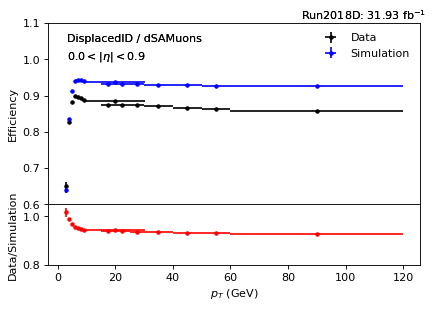

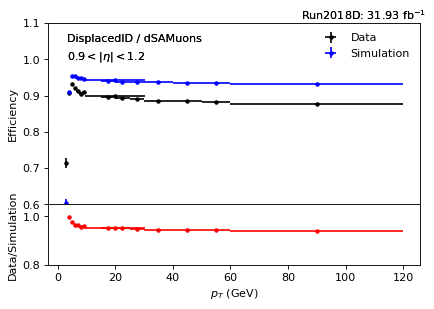

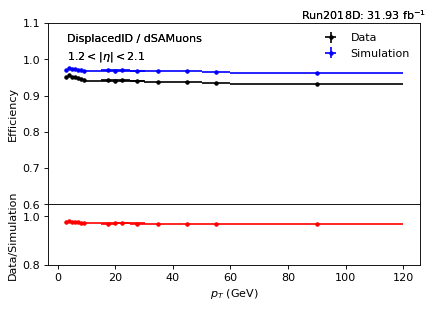

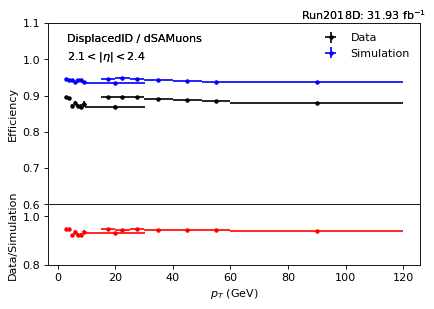

In [19]:
df_eff_Z = {subEra: get_eff(realized_abseta_pt_Z[subEra], ('abseta','pt')) for subEra in subEras_Z}
df_eff_JPsi = {subEra: get_eff(realized_abseta_pt_JPsi[subEra], ('abseta','pt')) for subEra in subEras_JPsi}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff_Z = {subEra: df_eff_Z[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras_Z}
    reduced_eff_jpsi = {subEra: df_eff_JPsi[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras_JPsi}
    bz = my_config_Z.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    ax0, ax1 = plot_both_effs(reduced_eff_Z, num, den, 'pt', config=my_config_Z, xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)
    plot_both_effs(reduced_eff_JPsi, num, den, 'pt', ax0=ax0, ax1=ax1, config=my_config_JPsi, xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

The scale factors agree very well up to |eta| < 2.1, but still seem to perform adequately in the very forward regime.

## Truth efficiency

This study compares the efficiency obtained with the T&P method in MC above against the *true* efficiency, which is possible to measure in MC by matching reconstructed muons with generated muons in dR (for example), and does not need a tag muon at all. In this case, we use a different config file with similar selections as the T&P one, except that it is applied to the _generated_ muons and not the tag muon. The true efficiency represents the "theoretical" maximum efficiency that should achievable with the T&P method, and is a good cross-check to perform when measuring a new object (e.g. dSA or displaced global muons).

Load the new config.

In [ ]:
my_config = Configuration('configs/displacedID_Z_truth.json')

Use previously defined functions but create a new one to plot MC vs true efficiencies.

In [ ]:
def plot_truth_eff(dfs, num, den, plotVar, xlabel='', additional_text='', high_quality=False):
    mpl.rcParams['figure.dpi'] = 300 if high_quality else 80
    
    bx = my_config.binning()[plotVar]
    
    sim = None
    if 'DY_madgraph' in dfs.keys():
        sim = 'DY_madgraph'
    elif 'JPsi_pythia8' in dfs.keys():
        sim = 'JPsi_pythia8'
    
    df_truth = dfs['truth']
    if sim is not None:
        df_mc = dfs[sim]

    x = [(bx[i]+bx[i+1])/2 for i in range(len(bx)-1)]
    xerr = [abs(x[i]-bx[i]) for i in range(len(bx)-1)]
    
    y = df_truth['eff'][1:len(bx)-1]
    yerr = df_truth['eff_err'][1:len(bx)-1]
        
    if sim is not None:
        y_mc = df_mc['eff'][1:len(bx)-1]
        yerr_mc = df_mc['eff_err'][1:len(bx)-1]
    
    if sim is not None:
        fig, (ax0, ax1) = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0, 'height_ratios':[3, 1]})
    else:
        fig, ax0 = plt.subplots(1)
    
    leg = []
    ax0.errorbar(x,y,xerr=xerr,yerr=yerr,fmt='.k')
    leg += ['Truth']
    if sim is not None:
        ax0.errorbar(x,y_mc,xerr=xerr,yerr=yerr_mc,fmt='.b')
        leg += ['Simulation']
        
    ax0.legend(leg, frameon=False)
        
    ax0.set_ylabel('Efficiency')
    ax0.set_ylim(0.91,1.02)
    ax0.set_xlabel(xlabel)
    ax0.text(0.05, 0.9, f'{num} / {den}', transform=ax0.transAxes)
    ax0.text(0.05, 0.8, additional_text, transform=ax0.transAxes)
    
    if sim is not None:
        ratio = y/y_mc
        err_ratio = ratio * ((yerr / y)**2 + (yerr_mc / y_mc)**2)**0.5
        ax1.errorbar(x,y/y_mc,xerr=xerr,yerr=err_ratio,fmt='.r')
        ax1.set_ylabel('Truth/Simulation')
        ax1.set_ylim(0.95,1.05)
        ax1.set_xlabel(xlabel)
        ax1.label_outer()
    
    ax0.label_outer()
    
    fig.show()

Here we are plotting Z MC samples (change to 'JPsi_pythia8' for J/Psi).

Note that this requires one to run the previous workflow above to obtain a 'df_eff' first.

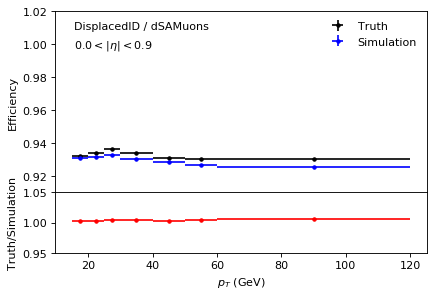

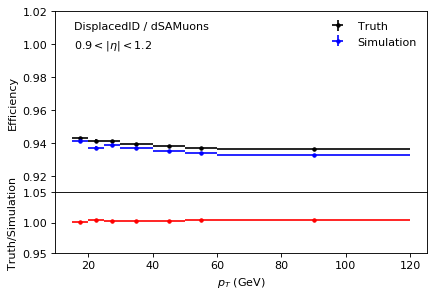

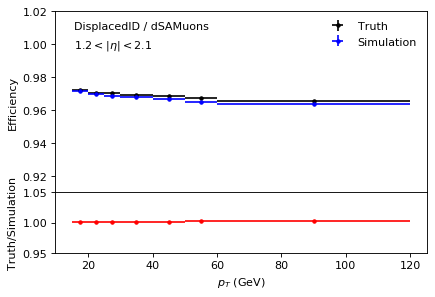

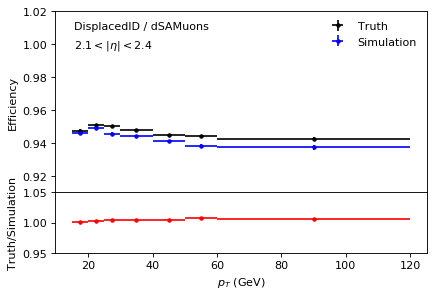

In [60]:
df_eff_truth = {subEra: get_eff(realized_abseta_pt[subEra], ('abseta','pt')) for subEra in subEras if subEra == 'DY_madgraph'}
for absetaBin in range(1,5):
    idx = pd.IndexSlice
    reduced_eff = {subEra: df_eff[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras if subEra == 'DY_madgraph'}
    reduced_eff_truth = {'truth': df_eff_truth[subEra].loc[idx[num,den,absetaBin,:]] for subEra in subEras if subEra == 'DY_madgraph'}
    reduced_eff_both = {**reduced_eff, **reduced_eff_truth}
    bz = my_config.binning()['abseta']
    additional_text = r'${low} < |\eta| < {high}$'.format(low=bz[absetaBin-1],high=bz[absetaBin])
    plot_truth_eff(reduced_eff_both, num, den, 'pt', xlabel=r'$p_{T}$ (GeV)', 
             additional_text=additional_text, 
             high_quality=False)

The efficiencies are very close, which is a good sign --- it means our T&P method is likely sound.